In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from IPython.display import HTML
%matplotlib notebook

from rotationAnimators import TwoClassTwoDimensionDataset, RotatingClassifierAnimation

In [2]:
DATA_SAMPLE = TwoClassTwoDimensionDataset(
    num_samples=2000, sep_dist=2.0, grid_steps=50
)

NUM_FRAMES_PER_ANIMATION = 90

<IPython.core.display.Javascript object>


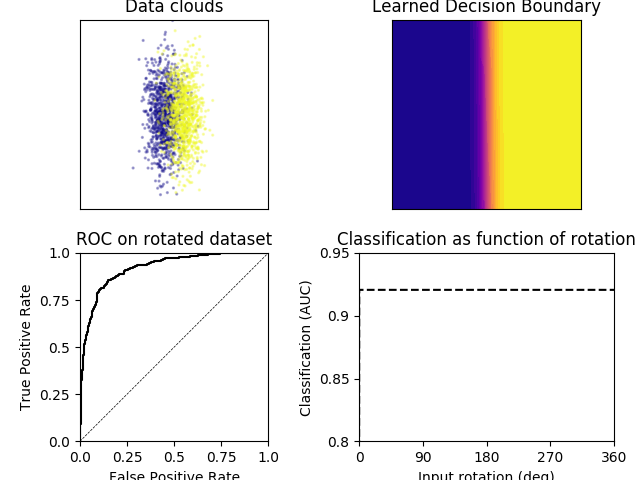

In [3]:
logistic_model = LogisticRegression(
    penalty='none',
    solver='newton-cg',
    fit_intercept=True
)

logistic_animator = RotatingClassifierAnimation(
    logistic_model,
    DATA_SAMPLE,
    min_auc=0.80
)

logistic_animation = logistic_animator.animate(
    num_frames=NUM_FRAMES_PER_ANIMATION
)
HTML(logistic_animation)

<IPython.core.display.Javascript object>


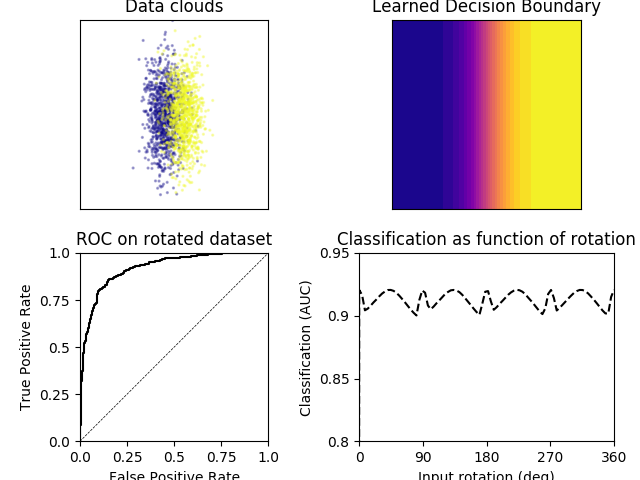

In [4]:
logistic_L1_model = LogisticRegression(
    penalty='l1',
    C=0.005,
    solver='liblinear',
    fit_intercept=True
)

logistic_L1_animator = RotatingClassifierAnimation(
    logistic_L1_model,
    DATA_SAMPLE,
    min_auc=0.80
)

logistic_L1_animation = logistic_L1_animator.animate(
    num_frames=NUM_FRAMES_PER_ANIMATION
)
HTML(logistic_L1_animation)

<IPython.core.display.Javascript object>


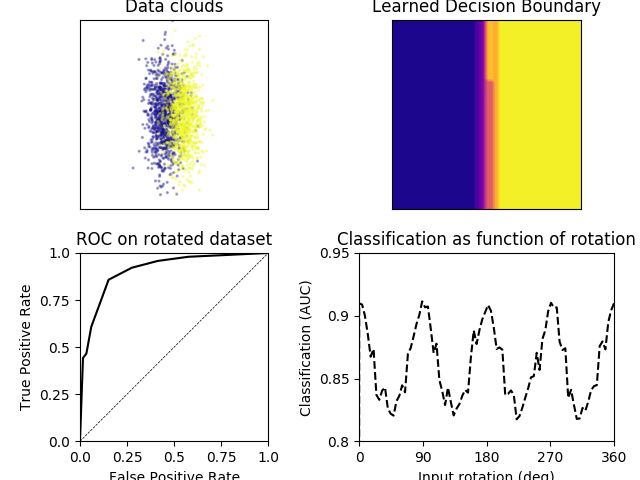

In [5]:
tree_model = DecisionTreeClassifier(
    max_depth=3
)

tree_animator = RotatingClassifierAnimation(
    tree_model,
    DATA_SAMPLE,
    min_auc=0.8
)

tree_animation = tree_animator.animate(
    num_frames=NUM_FRAMES_PER_ANIMATION
)

HTML(tree_animation)